## the purpose of this script is to study the effect of speaker and the perplexity of next DA given the current dialgo state

In [49]:
%matplotlib inline
from swda import Transcript
from swda import CorpusReader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import random
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from scipy.sparse import csr_matrix, hstack
import csv

### Functions

In [396]:
def plot_confusion_matrix(cm, tag_list, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(tag_list))
    plt.xticks(tick_marks, tag_list, rotation=45)
    plt.yticks(tick_marks, tag_list)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def norm_tokens(tokens):
    result = []
    for t in tokens:
        if not ('[' in t or ']' in t or
               '{' in t or '}' in t or 
               '+' in t or '/' in t or 
               '--' in t or "#" in t):
            result.append(t)
    return result
    
def should_append(utt):
    if utt.damsl_act_tag() == '+':
        return True
    else:
        return False
    
def get_prev_n(ys, cur_idx, prev_n):
    if cur_idx - prev_n < 0:
        return None
    return ys[cur_idx - prev_n]

def get_next_n(ys, cur_idx, next_n):
    if cur_idx + next_n >= len(ys):
        return None
    return ys[cur_idx + next_n]
def get_features(utts, ys, callers, tag_list, prev_n_utt, next_n_utt, use_speaker):
    num_utts = len(utts)
    num_base = 3
    tag_size = len(tag_list)
    speakers = ['A', 'B']
    if use_speaker:
        num_base = 5
        tag_size *= 2
                
    ext_X = np.zeros((num_utts,num_base + tag_size * prev_n_utt + tag_size * next_n_utt))
    for idx, utt in enumerate(utts):
        spk_index = speakers.index(callers[idx])
     
        if "wh" in utt.lower():
            ext_X[idx, 0] = 1
        if "?" in utt:
            ext_X[idx, 1] = 1
        if "!" in utt:
            ext_X[idx, 2] = 1
        if use_speaker:
            # caller
            ext_X[idx, 3 + spk_index] = 1
                
        # context
        for i in range(1, prev_n_utt+1):
            prev_da = get_prev_n(ys, idx, i)
            if prev_da:
                if use_speaker:
                    prev_spk = speakers.index(get_prev_n(callers, idx, i))
                    ext_X[idx, num_base + (i-1) * tag_size + prev_spk * len(tag_list) + int(prev_da)] = 1
                else:
                    ext_X[idx, num_base + (i-1) * tag_size + int(prev_da)] = 1
                    
        for i in range(1, next_n_utt+1):
            next_da = get_next_n(ys, idx, i)
            if next_da:
                if use_speaker:
                    next_spk = speakers.index(get_next_n(callers, idx, i))
                    ext_X[idx, num_base + prev_n_utt * tag_size + (i-1)*tag_size + next_spk * len(tag_list) + int(next_da)] = 1
                else:
                    ext_X[idx, num_base + prev_n_utt * tag_size + (i-1)*tag_size + int(next_da)] = 1
                    
    return ext_X

    
def norm_label(utt, merge=False):
    label = utt.damsl_act_tag()
    if (label.startswith("fo")):
        label = 'fo_o_fw_by_bc'
    #if (label == 'sv'):
    #    label = 'sd'
    if merge:
        return tag_map[label]
    else:
        return label

### Read CSVs

In [271]:
# read the tag description
tag_detail = {}
with open('./swda/tag_description.csv', 'r') as csv_file:
    tag_reader = csv.reader(csv_file)
    for row in tag_reader:
        tag_detail[row[1]] = (row[0], row[2])
        
tag_map = {}
with open('./swda/tag_mapping.csv', 'r') as csv_file:
    tag_reader = csv.reader(csv_file)
    for row in tag_reader:
        tag_map[row[1]] = row[2]

### Create Corpus

In [401]:
corpus = CorpusReader('swda')
all_utts = []
all_targets = []
all_callers = []
all_trans_id = []
tag_set = set()
cnt = 0;
last_idx = {'A':-1, 'B':-1}
black_list = []

#create dataset
cnt = 0
for utt in corpus.iter_utterances(display_progress=False):
    tokens = utt.text_words()
    caller = utt.caller
    label = norm_label(utt, merge=True)
    b_should_append = should_append(utt)
    
    # check for merging
    if b_should_append:
        idx = last_idx.get(caller)
        if idx >= 0:
            all_utts[idx] = all_utts[idx] + ' ' + ' '.join(norm_tokens(tokens))
            continue
        else:
            print "ERROR"
            break
    
    # check if empty
    norm_text = ' '.join(norm_tokens(tokens))
    if not norm_text:
        if label == 'x' and utt.text:
            norm_text = utt.text
        else:       
            continue
        
    # update previous speaker utt
    last_idx[caller] = cnt
    
    # save
    all_utts.append(norm_text)
    all_targets.append(label)
    all_callers.append(caller)
    tag_set.add(label)
    all_trans_id.append(utt.utterance_index)
    cnt += 1

In [405]:
print [(x,y,z) for x, y, z in zip(all_targets, all_trans_id, all_callers)]

[('other', 1, 'A'), ('question', 1, 'A'), ('question', 2, 'B'), ('question', 5, 'A'), ('inform', 6, 'B'), ('request', 6, 'B'), ('other', 6, 'B'), ('request', 6, 'B'), ('request', 6, 'B'), ('confirm', 7, 'A'), ('question', 7, 'A'), ('confirm', 8, 'B'), ('inform', 8, 'B'), ('inform', 10, 'B'), ('inform', 10, 'B'), ('inform', 10, 'B'), ('confirm', 11, 'A'), ('confirm', 13, 'A'), ('disconfirm', 14, 'B'), ('inform', 14, 'B'), ('inform', 14, 'B'), ('inform', 14, 'B'), ('inform', 14, 'B'), ('confirm', 15, 'A'), ('question', 16, 'B'), ('confirm', 17, 'A'), ('question', 18, 'B'), ('confirm', 19, 'A'), ('non-verbal', 20, 'B'), ('confirm', 21, 'A'), ('inform', 21, 'A'), ('other', 21, 'A'), ('inform', 21, 'A'), ('inform', 21, 'A'), ('confirm', 22, 'B'), ('inform', 23, 'A'), ('inform', 23, 'A'), ('confirm', 24, 'B'), ('question', 25, 'A'), ('confirm', 26, 'B'), ('inform', 26, 'B'), ('inform', 26, 'B'), ('inform', 26, 'B'), ('inform', 26, 'B'), ('confirm', 27, 'A'), ('inform', 28, 'B'), ('question',

In [378]:
train_size = int(len(all_utts)*0.9)
test_size = len(all_utts) - train_size

train_utts = all_utts[0:train_size]
test_utts = all_utts[train_size:train_size+test_size]

y_train = np.zeros(train_size)
y_test = np.zeros(test_size)

train_caller = all_callers[0:train_size]
test_caller = all_callers[train_size:train_size+test_size]

tag_list = list(tag_set)

tag_names = [x[0] for x in tag_detail.values()]

print str(len(y_train)) + " train"
print str(len(y_test)) + " test"

for idx, target in enumerate(all_targets):
    if idx >= train_size + test_size:
        break
    if idx < train_size:
        y_train[idx] = tag_list.index(target)
    else:
        y_test[idx-train_size] = tag_list.index(target)

183280 train
20365 test


### Classificiaton without context

In [379]:
representation = CountVectorizer(min_df=0, ngram_range=(1,2), lowercase=False)
representation.fit(train_utts)
ngram_train = representation.transform(train_utts)
ngram_test = representation.transform(test_utts)
print ngram_train.shape

(183280, 269485)


In [290]:
# getting extra feature
ext_X_train = get_features(train_utts, y_train, train_caller, tag_list, 0, 0, False)
ext_X_test = get_features(test_utts, y_test, test_caller, tag_list, 0, 0, False)

# put it together with non-ngram features
X_train = hstack([ngram_train, csr_matrix(ext_X_train)])
X_test = hstack([ngram_test, csr_matrix(ext_X_test)])
print X_train.shape

(183326, 269492)


In [291]:
clf = LinearSVC(C=0.1).fit(X_train, y_train)
predicted = clf.predict(X_test)

0.739175257732
               precision    recall  f1-score   support

           aa       0.41      0.40      0.40       686
           bd       0.57      0.40      0.47        10
           ad       0.70      0.25      0.37        75
          b^m       0.50      0.02      0.03        56
           t3       1.00      0.50      0.67        10
          qrr       0.46      0.40      0.43        15
           ar       0.25      0.06      0.10        17
           fp       0.89      0.67      0.76        12
            %       0.67      0.79      0.72      1545
           nn       0.52      0.93      0.67       138
           no       0.00      0.00      0.00        22
           na       0.00      0.00      0.00        74
           ^2       0.33      0.01      0.02        95
           ng       0.50      0.12      0.20        40
           ny       0.45      0.04      0.08       297
         qw^d       0.00      0.00      0.00         6
         qy^d       0.21      0.04      0.06     

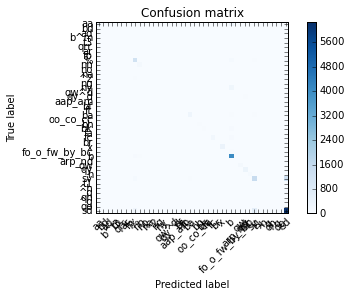

In [292]:
print np.mean(predicted == y_test)
print metrics.classification_report(y_test, predicted, target_names=[tag_list[int(i)] for i in list(set(y_test))])
plot_confusion_matrix(cm=metrics.confusion_matrix(y_test, predicted), tag_list=[tag_list[int(i)] for i in list(set(y_test))])

### Classificiaton with context (DA) and speaker

In [389]:
# getting extra feature (Previous dialog act)
prev_n_utt = 1
next_n_utt = 0
use_speaker = True

ext_X_train = get_features(train_utts, y_train, train_caller, tag_list, prev_n_utt, next_n_utt, use_speaker)
ext_X_test = get_features(test_utts, y_test, test_caller, tag_list, prev_n_utt, next_n_utt, use_speaker)
# combine with n-gram
#X_train = hstack([ngram_train, csr_matrix(ext_X_train)])
#X_test = hstack([ngram_test, csr_matrix(ext_X_test)])
X_train = csr_matrix(ext_X_train)
X_test =  csr_matrix(ext_X_test)
print X_train.shape

(183280, 23)


In [390]:
clf = LinearSVC(C=0.1).fit(X_train, y_train)
predicted = clf.predict(X_test)

0.556788607906
                precision    recall  f1-score   support

    non-verbal       0.00      0.00      0.00       388
       confirm       0.39      0.06      0.10      6009
       request       0.00      0.00      0.00        75
non-understand       0.00      0.00      0.00        24
      question       0.89      0.68      0.77       948
        inform       0.55      0.97      0.70     10427
         other       0.00      0.00      0.00      1988
       goodbye       0.85      0.81      0.83       278
    disconfirm       0.00      0.00      0.00       228

   avg / total       0.45      0.56      0.44     20365



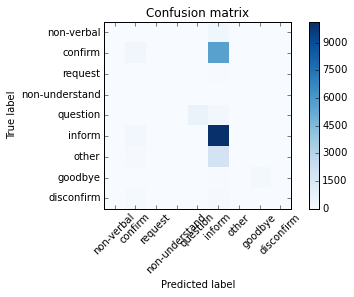

In [391]:
print np.mean(predicted == y_test)
print metrics.classification_report(y_test, predicted, target_names=[tag_list[int(i)] for i in list(set(y_test))])
plot_confusion_matrix(cm=metrics.confusion_matrix(y_test, predicted), tag_list=[tag_list[int(i)] for i in list(set(y_test))])

### Study a little bit on the transititon matrix

In [394]:
trans_mat = np.zeros((len(tag_list), len(tag_list)))